In [1]:
import dores
import pandas as pd
from tqdm.notebook import trange
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', 1000)
import numpy as np
import plotly.graph_objects as go
import datetime

In [2]:
filename = './data/LichteilandGoerree/hp.csv'
dataset = dores.import_data(filename)
dataset['VALUE'] = dataset['VALUE'] / 100
dataset['Tp'] = 5 * (dataset['VALUE']) ** 0.5
dataset.columns = ['DATETIME', 'WAVE HEIGHT', 'WAVE PERIOD']

In [26]:
date_list = pd.DataFrame({'date': np.arange(
        start=datetime.datetime(2010, 1, 1),
        stop=datetime.datetime(2017, 11, 1),
        step=datetime.timedelta(minutes=10)
    )
}).set_index('date')

periods = []

# Select year/month/day/period
dates = date_list[date_list.index.month == 5]

for i in trange(1000):
    idx = np.random.randint(0, len(dates))
    startDate = dates.index[idx]
    sim = dores.DiscreteEventSimulation(start_date=startDate)
    sim.offshore_environment(dataframe=dataset)
    sim.create_entities()
    sim.start_simulation()
    periods.append(sim.get_project_length())

In [138]:
hist = go.Histogram(
    x=periods,
    xbins={'size': 1},
    cumulative={'enabled': True},
    histnorm='probability',
    marker=dict(color='red', line=dict(color='black', width=1)),
    name='cumulative distribution'
)

fig = go.Figure(data=hist)

fig.add_trace(go.Scatter(
    x=dores.cumulative_dist(periods).iloc[::1]['X'],
    y=dores.cumulative_dist(periods).iloc[::1]['EDF'],
    line={'shape': 'spline', 'color': 'blue'},
    name='exceedance probability'
))

fig.update_layout(
    xaxis_title='Estimated construction period [days]',
    yaxis_title='Probability [-]',
    title='Cumulative distribution function ECP',
    plot_bgcolor='white'
)

fig.show()

In [49]:
wave_height = dores.import_data('./data/LichteilandGoerree/hp.csv').set_index('DATETIME')
wave_height = wave_height.rename(columns={'VALUE': 'HS'})

In [50]:
direction = dores.import_data('./data/LichteilandGoerree/dir.csv').set_index('DATETIME')
direction = direction.rename(columns={'VALUE': 'THETA'})

In [72]:
wave_period = dores.import_data('./data/LichteilandGoerree/tp.csv').set_index('DATETIME')
wave_period = wave_period.rename(columns={'VALUE': 'TP'})

In [112]:
wave_params = wave_height.join([direction, wave_period]).reset_index()

In [177]:
wave_params['YEARS'] = wave_params['DATETIME'].dt.year
wave_params['DATE'] = wave_params['DATETIME'].dt.strftime('%d-%m %H:%M:%S')

wave_params = wave_params.drop(
    wave_params[
        (wave_params['DATETIME'].dt.month == 2)
        & ((wave_params['DATETIME'].dt.day == 29))
    ].index
)

wave_params['DATE'] = pd.to_datetime(wave_params['DATE'], format='%d-%m %H:%M:%S')

In [248]:
pv = pd.pivot_table(wave_params, 
                    values='HS', 
                    index='DATE',
                    columns='YEARS',
                    aggfunc=np.mean)

pv = pv.resample('D').max()

# pv['MIN'] = pv.iloc[:, :9].apply(np.mean, axis=1)
# pv['AVG'] = pv.iloc[:, :9].apply(np.min, axis=1)
# pv['MAX'] = pv.iloc[:, :9].apply(np.max, axis=1)
pv['P05'] = pv.iloc[:, :9].apply(lambda x: np.nanpercentile(x, 5), axis=1)
pv['P50'] = pv.iloc[:, :9].apply(lambda x: np.nanpercentile(x, 50), axis=1)
pv['P95'] = pv.iloc[:, :9].apply(lambda x: np.nanpercentile(x, 95), axis=1)


In [251]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=pv.index,
        y=pv['P50'],
        name='Average wave height',
        mode='lines',
        line=dict(color='red', shape='spline'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=pv.index,
        y=pv['P95'],
        name='Upper bound',
        mode='lines',
        marker=dict(color='#444'),
        line=dict(width=1, shape='spline'),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=pv.index,
        y=pv['P05'],
        name='Lower boud',
        marker=dict(color='#444'),
        line=dict(width=1, shape='spline'),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    )
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Significant wave height (Hs) [m]'
)

<AxesSubplot:xlabel='YEARS'>

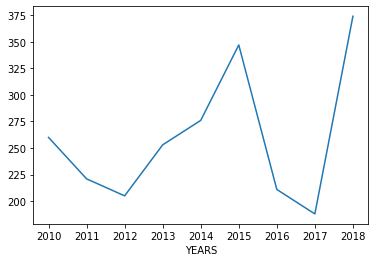

In [254]:
pv.iloc[0, :9].plot()